In [14]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor, SGDClassifier
from  math import radians

In [19]:
sns.set_style('whitegrid')
sns.set_context(rc={
    'axes.titlesize':19,
    'axes.labelsize':17,
    'xtick.labelsize':13,
    'ytick.labelsize':14
})

In [42]:
def thousands(y,pos):
    """ 
    Function is used to change the tick label
    It requires 2 argument: y is the tick value and pos is the position of the tick label.
    Function returns the string format for the tick label
    """
    return '{:,.0f}'.format(y)

OUTLINE:

+data introduction

+data preprocessing
    
    assess data quality 
    
    clean data (handling missing values; handling outliers;)
    
    transform data (doing univariate, multivariate graphical representation to explore the data; feature engineering 
    
+prediction
    
    predict trip distance (regression)
    
    predict fare amount (regression)
    
    predict payment type(classifcation)

# DATA INTRODUCTION

The dataset is called NYC taxi cab which is collected from: 
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The data represents the taxi trips during 2020 in NYC. There are around 24 millions of rows. 

Each row represents a trip. Columns display relevant information to a trip such as the starting time, ending time, the fare amount, the pick up location , drop off location, etc

The data used in this notebook has been partially processed. 

Only 10% of 24 millions rows is used which is not too large but sufficient to showcase the ability in handling the dataset having millions of rows, in doing exploratory data analysis, and in applying ML methods into real world problems

In [15]:
initial = pd.read_csv('D:/TOPIC_RELATED VOCABULARY IELTS/Finland/aalto/cemsschool/Other Courses/programming course for DS/project//trip_data/nyc_10%.csv' )

Some information beforehand:
    
    +meaning of columns
        
        'PUlon', 'PUlat', 'DOlon', 'DOlat','PULocationID','DOLocationID': are the coordinates, and ID of the location (pickup location and drop off location)

        'PUmonth', 'PUhour', 'DOmonth','DOhour', 'PUday', 'DOday', 'PUweekend', 'DOweekend': are the time when the trip starts and ends
   
       'duration','trip_distance': are how long and how far the trip takes
       
       'passenger_count': indicates how many passenger
       
       'RatecodeID',  'payment_type', 'fare_amount', 'extra', 'mta_tax','tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount','congestion_surcharge': are relevant to the money and payment side
       
  
    + unit of measurement (duration column: minutes; trip_distance column: miles; fare_amount, extra, mta_tax, tip_amount, tolls_amount, total_amount: cent)
    
    + other facts: 4 payment types(credit card, cash, no charge, dispute) and 6 ratecodeID; there are only 263 locationID; charge should be non negative values

# DATA PREPROCESSING

## Data quality assessment

In [5]:
initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2383893 entries, 0 to 2383892
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Unnamed: 0.1           int64  
 2   PUlon                  float64
 3   PUlat                  float64
 4   DOlon                  float64
 5   DOlat                  float64
 6   PUmonth                int64  
 7   PUhour                 int64  
 8   DOmonth                int64  
 9   DOhour                 int64  
 10  PUweekday              object 
 11  DOweekday              object 
 12  PUweekend              int64  
 13  DOweekend              int64  
 14  duration               int64  
 15  passenger_count        int64  
 16  trip_distance          float64
 17  RatecodeID             int64  
 18  PULocationID           int64  
 19  DOLocationID           int64  
 20  payment_type           int64  
 21  fare_amount            int64  
 22  extra             

From the info table: 

+ the data has around 2mil4 observations and there are 29 columns: 2 columns contain categorical data(Pick up weekday(PUWeekday) and Drop Off weekday(DOWeekday)) and 27 columns have data types for numeric variables (i.e: int64 or float64)


+ However, on second thought, there are some mismatch in data types. Some columns should have had been defined as categorical or object type since they are categorical variables rather than numeric variables. Examples could be RatecodeID, payment_type, LocationID, Weekend (0,1 indicates whether it is weekend or not). Bear this in mind, we should not do usual computation on them (sum, subtract, etc)


+ Though columns such as month, day, hour incorporate numbers, these do not behave like usual numbers we know but rather they have the cyclic properties that should be taken into account. E.g: As for month, after 12, it should be 1 rather than 13. We would find ways to handle them later



In [16]:
#Drop two meaningless columns (i.e:Unnamed)
initial= initial.iloc[:,2::]

In [17]:
pd.options.display.float_format='{:,.2f}'.format
initial.describe(include='all').iloc[:,:15] # include also the categorical columns

,PUlon,PUlat,DOlon,DOlat,PUmonth,PUhour,DOmonth,DOhour,PUweekday,DOweekday,PUweekend,DOweekend,duration,passenger_count,trip_distance
count,"2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00",2383893,2383893,"2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00"
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,7,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thu,Thu,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383106,382637,NaN,NaN,NaN,NaN,NaN
mean,-73.97,40.76,-73.97,40.76,4.39,13.91,4.39,13.98,NaN,NaN,0.11,0.11,14.81,1.47,2.75
std,0.04,0.03,0.03,0.03,3.83,5.55,3.83,5.62,NaN,NaN,0.31,0.32,61.67,1.11,31.59
min,-74.23,40.53,-74.23,40.53,1.00,0.00,1.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00
25%,-73.99,40.74,-73.99,40.74,1.00,10.00,1.00,10.00,NaN,NaN,0.00,0.00,6.00,1.00,0.97
50%,-73.98,40.76,-73.98,40.76,2.00,14.00,2.00,15.00,NaN,NaN,0.00,0.00,10.00,1.00,1.60
75%,-73.97,40.77,-73.96,40.78,8.00,18.00,8.00,18.00,NaN,NaN,0.00,0.00,16.00,1.00,2.88


In [63]:
initial.describe(include='all').iloc[:,15::]

,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration_sec
count,"2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00","2,383,893.00"
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.05,164.67,162.09,1.28,12.28,1.07,0.50,2.09,0.27,0.30,18.05,2.27,888.54
std,0.78,66.24,70.66,0.48,258.30,1.24,0.04,2.60,1.75,0.04,258.41,0.75,"3,700.36"
min,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.30,0.00,-2.50,0.00
25%,1.00,125.00,107.00,1.00,6.50,0.00,0.50,0.00,0.00,0.30,11.15,2.50,360.00
50%,1.00,162.00,162.00,1.00,9.00,0.50,0.50,1.86,0.00,0.30,14.16,2.50,600.00
75%,1.00,234.00,234.00,2.00,13.50,2.50,0.50,2.85,0.00,0.30,19.30,2.50,960.00


From the description table:

+ there exist some extremely large values (outliers)  in duration, trip_distance, ratecodeID, fare_amount, extra, mta_tax, tip_amount, tolls_amount, total_amount columns


+ there are some negative values in non-negative variable columns(i.e congestion_surcharge, improvement_surcharge)

### handle mismatch data types, mismatch data values 

In [77]:
    # categorical columns
initial.rename({'PUweekday':'PUday','DOweekday':'DOday'},axis=1, inplace=True)
    for col in initial.columns:
        if(initial[col].dtypes != 'int64' and initial[col].dtypes != 'float64'):
            print('Unique values in {} are {}'.format(col,np.unique(initial[col])))

Unique values in PUday are ['Fri' 'Mon' 'Sat' 'Sun' 'Thu' 'Tue' 'Wed']
Unique values in DOday are ['Fri' 'Mon' 'Sat' 'Sun' 'Thu' 'Tue' 'Wed']


We could say that the values used in columns are consistent. There is no mismatch data (e.g: Fri and Friday )

In [18]:
    # numeric columns
# convert from cent to dollars for currency columns
initial[['fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'total_amount']]=initial[['fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'total_amount']]/100

# convert from minutes to seconds for duration column
initial['duration_sec']=initial['duration']*60

## Data cleaning

### detect missing values

In [27]:
missing_df = initial.isnull().sum(axis=0).reset_index()
missing_df.columns=['Names','Number of missing values']
missing_df

,Names,Number of missing values
0,PUlon,0
1,PUlat,0
2,DOlon,0
3,DOlat,0
4,PUmonth,0
5,PUhour,0
6,DOmonth,0
7,DOhour,0
8,PUweekday,0
9,DOweekday,0


The dataset at this point seems to contain no missing values

### detect and handle outliers (due to data entry error)
methods: deletion

Firstly, let's handle the data that are nonsensical which could be due to the errors cropping up during the data input process. To do so, I set some criteria for what to be considered to be sensible

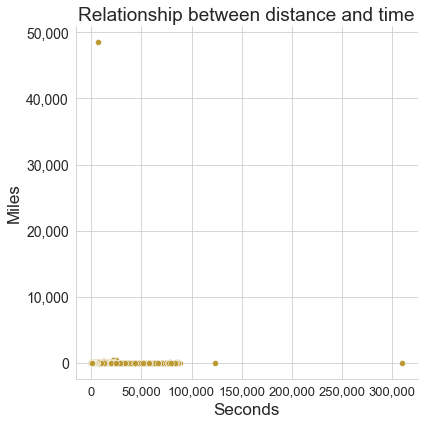

In [34]:
formatter= FuncFormatter(thousands)
g= sns.FacetGrid(data=initial,height=6)
g.map(sns.scatterplot,'duration_sec','trip_distance',color=sns.color_palette('husl')[1])
g.set(title='Relationship between distance and time')
g.set_axis_labels('Seconds','Miles')
g.axes[0][0].xaxis.set_major_formatter(formatter)
g.axes[0][0].yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

Speed= Distance/ Time

From the scatterplot showing the relationship between duration_sec and trip_distance, we could tell that there are some strange observations. 
Let me clarify my point:
It is believed that for a taxi in nyc:

+it takes around an hour for a distance of 21 miles. Here I set the loose upper bound  which is around 80 miles per hour (0.02 miles per second).
https://en.wikipedia.org/wiki/Taxiing#cite_note-6

+we could also assume that no matter how congestred the traffic is, the taxi should be able to travel at least 1 mile per hour. So this is the lower bound (0.0002 miles per second)

So, for any observations that are outside of this condition, it is very likely that they are just the  erroneous entries. Any data points like this could be dropped out

In [30]:
c1= (initial['trip_distance']/initial['duration_sec'])<=0.02 
c2= (initial['trip_distance']/initial['duration_sec'])>0.0002

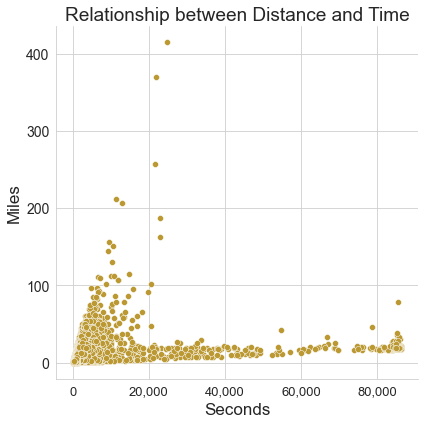

In [35]:
g= sns.FacetGrid(data=initial[c1 & c2],height=6)
g.map(sns.scatterplot,'duration_sec','trip_distance',color=sns.color_palette('husl')[1])
g.set(title='Relationship between Distance and Time')
g.set_axis_labels('Seconds','Miles')
g.axes[0][0].xaxis.set_major_formatter(formatter)
g.axes[0][0].yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

the data becomes much more sensible now.

There are some conditions for other columns:

+ there are only 4 payment types(credit card, cash, no charge, dispute) and 6 ratecodeID


+ there are only 263 locationID


+ charge should be non negative values

In [36]:
# Payment and Ratecode conditions
cPay = initial['payment_type']<=4
cRate=  initial['RatecodeID']<=6

# LocationID conditions
cLocPU=initial['PULocationID']<=263
cLocDO=initial['DOLocationID']<=263

# Charge conditions
cchaIm=initial['improvement_surcharge']>=0
cchaCo=initial['congestion_surcharge']>=0

In [79]:
initial_trimmed= initial[c1& c2 &cPay & cRate & cLocPU & cLocDO & cchaIm & cchaCo]

### detect and handle other types of outliers 
methods: clipping

As for the outliers that are not because of data entry error, I applied clipping methods to handle them

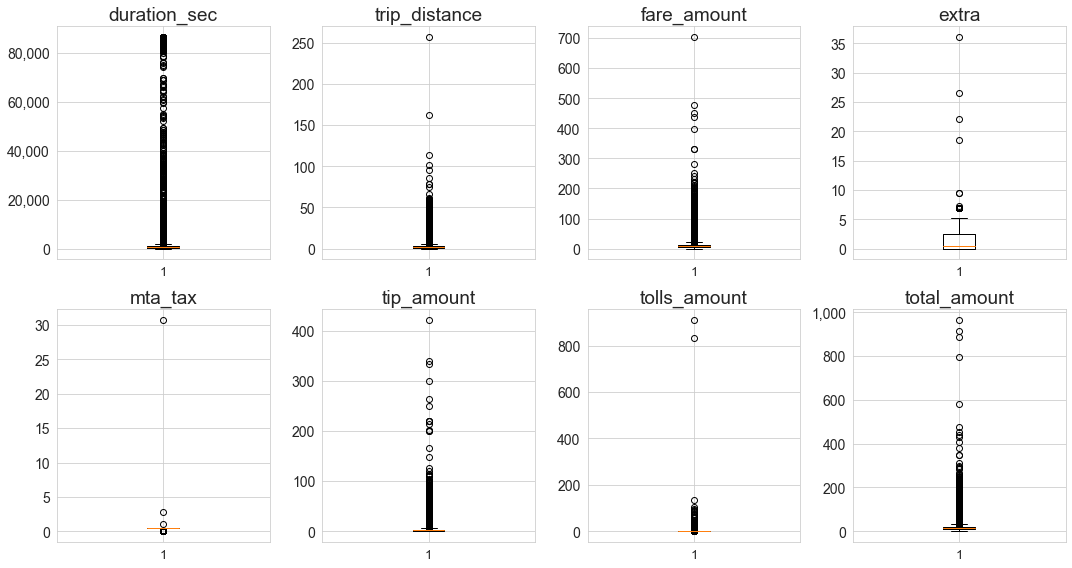

In [39]:
fig,ax= plt.subplots(2,4,figsize=(15,8))
outliers_col_names= ['duration_sec','trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']
for j in np.arange(0,2):
        for i in np.arange(0,4):    
            if (j==0): 
                col= outliers_col_names[i]
            else:        
                col= outliers_col_names[i+4]
            ax[j,i].boxplot(initial_trimmed[col])
            ax[j,i].set_title('{}'.format(col))
            ax[j,i].yaxis.set_major_formatter(formatter)
plt.tight_layout()    
plt.show()

In [103]:
def clipping(col):
    """
    Function used to handle outliers. Any values that are lower than percentile 1% or exceed perecentile 99% would be set to be the values at 1% or 99% respectively
    Function accepts Series as its argument
    It returns the clipped Series
    """
    return col.clip(lower=col.quantile(0.01),upper=col.quantile(0.99))

for col in outliers_col_names:
    transformed= 'clipped_'+col
    initial_trimmed[transformed]=clipping(initial_trimmed[col])

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_4728/2461979249.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_trimmed[transformed]=clipping(initial_trimmed[col])


In [41]:
pd.options.display.float_format='{:,.2f}'.format
initial_trimmed.describe(include='all').iloc[:,18:]

,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration_sec,clipped_duration_sec,clipped_trip_distance,clipped_fare_amount,clipped_extra,clipped_mta_tax,clipped_tip_amount,clipped_tolls_amount,clipped_total_amount
count,"2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00","2,308,850.00"
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.27,11.80,1.09,0.50,2.09,0.25,0.30,17.59,2.32,733.94,719.90,2.72,11.73,1.09,0.50,2.07,0.23,17.52
std,0.46,9.68,1.24,0.03,2.45,1.58,0.00,12.02,0.64,916.09,534.24,3.24,9.24,1.23,0.00,2.16,1.17,11.46
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,60.00,60.00,0.30,3.50,0.00,0.50,0.00,0.00,6.62
25%,1.00,6.50,0.00,0.50,0.00,0.00,0.30,11.15,2.50,360.00,360.00,1.00,6.50,0.00,0.50,0.00,0.00,11.15
50%,1.00,9.00,0.50,0.50,1.95,0.00,0.30,14.16,2.50,600.00,600.00,1.63,9.00,0.50,0.50,1.95,0.00,14.16
75%,2.00,13.00,2.50,0.50,2.85,0.00,0.30,19.12,2.50,960.00,960.00,2.90,13.00,2.50,0.50,2.85,0.00,19.12


Having a look at the max values from clipped_columns in the table above, we see outliers values have been dealt with rather okay

## Data transformation

### explore the data by univariate and multivariate graphical representation

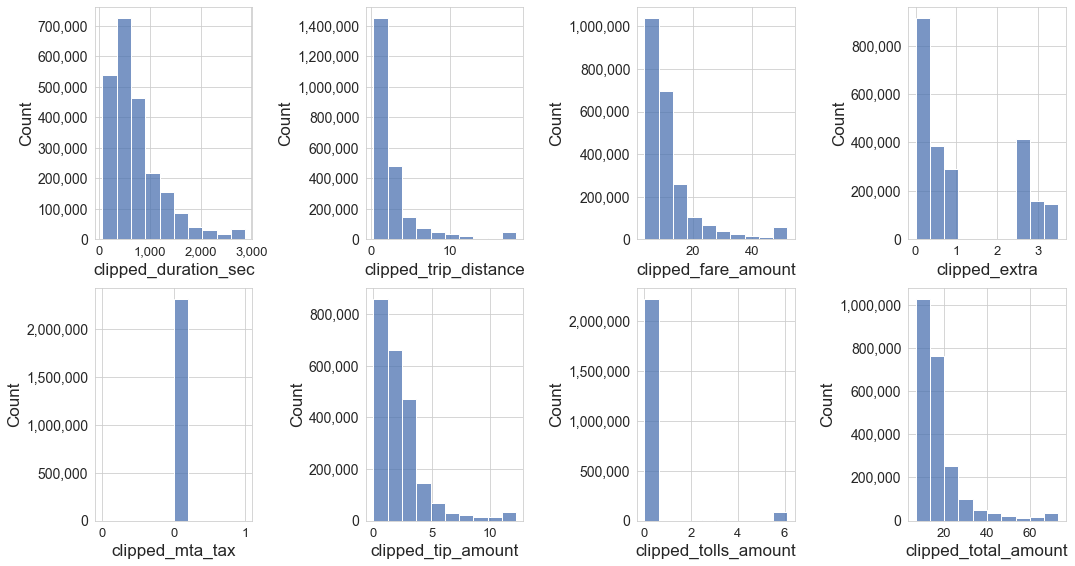

In [118]:
    # Univariate graphical representation:
fig, ax= plt.subplots(2,4,figsize=(15,8))
for j in np.arange(0,2):
    for i in np.arange(0,4):
        if (j==0):
            col= outliers_col_names[i]
        else:
            col=outliers_col_names[i+4]
        axNe= ax[j,i]
        sns.histplot(initial_trimmed['clipped_'+col], bins=10,color= sns.color_palette('deep')[0], ax=axNe)
        axNe.yaxis.set_major_formatter(formatter)
        axNe.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()


From the marginal distribution of the columns, we could observe that:

+ almost all trips do not travel further than 10 miles. It is sensible in the sense that within a city, people often hail a taxi only for short trip: to move around some popular destinations in the central business district or around the entertainment district. There is also a smaller proportion of trips  whose distances are more than 10 miles. They could very likely to be the ones heading to one of the international airports at NYC. Since the airports are often located quite far away from the business center, these trips often have larger distance. 


+ not only the trip_distance hovers around 0, the majority of duration, fare_amount, tip_amount, toll_amount, and total_amount values also concentrate a lot of mass at the region close to 0. This is reasonable since these factors could be explained by the trip_distance. The further the trip is, the longer it takes. The further and long the trip is, the more amount of fare and tip that could be paid.


+ the mta_tax seems to be fixed. So it does not change much no matter how far or how long the trip could take



##### Now, let's inspect whether there is any difference in the duration of a trip between weekend and weekday

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


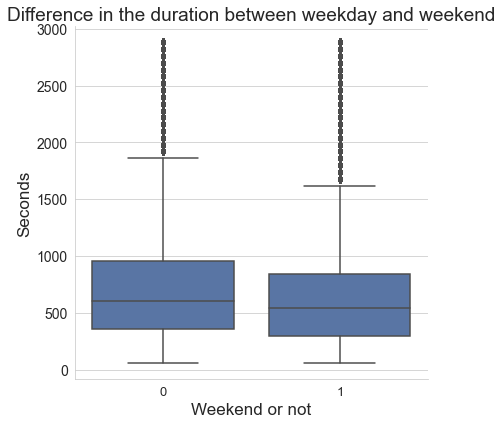

In [48]:
g= sns.FacetGrid(data=initial_trimmed,height=6)
g.map(sns.boxplot,'PUweekend','clipped_duration_sec', color=sns.color_palette('deep')[0])
g.set(title='Difference in the duration between weekday and weekend')
g.set_axis_labels('Weekend or not', 'Seconds')
plt.tight_layout()
plt.show()

From the boxplot, we could visually see there seems to have a slightly lower quantiles(25th, median, 75th) in the duration of trips during weekend. 

This is interesting.

An initial guess could be that there are multi purposes when taking a taxi trip: commuters travel from their residential areas to the business centre, businessmen travel from and to the international airports, people who just GO OUT for entertaining purpose. During weekend, the purpose seems to be less various: most of people just hang out within the city center where most of the exiciting places are located
As a result, the trip having larger distance may take longer. 

Another reason could be that during weekday, the traffic congestion within a city is likelier to happen compared against the weekend, which makes for longer duration for the 

##### Let's confirm the thinking by having a look at the difference in the trip distance between weekend and weekday

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


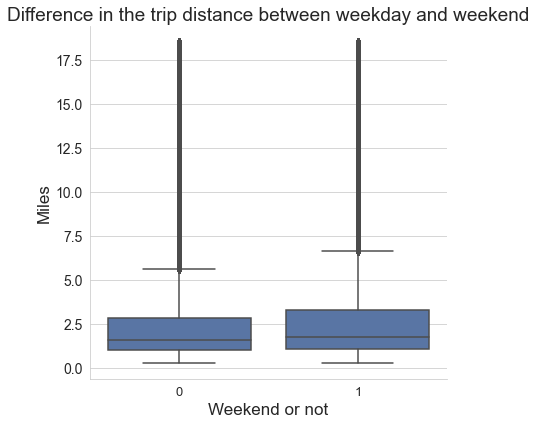

In [51]:
g= sns.FacetGrid(data=initial_trimmed,height=6)
g.map(sns.boxplot,'PUweekend','clipped_trip_distance', color=sns.color_palette('deep')[0])
g.set(title='Difference in the trip distance between weekday and weekend')
g.set_axis_labels('Weekend or not', 'Miles')
plt.tight_layout()
plt.show()

Well, our first reasoning does not seem to hold anymore. We perceived that quantiles of trip distance during weekend are higher than those during weekday.

But the second reasoning is still reasonable. Maybe the difference in the level of traffic jam is the cause of longer duration during weekday

##### Next, is there more trips on any specific  day during a week?

In [53]:
numTripByDay= initial_trimmed.groupby(['PUweekday'])['clipped_trip_distance'].count().reset_index()

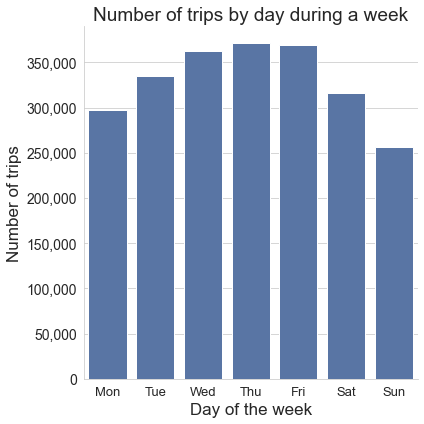

In [55]:
g= sns.FacetGrid(data=numTripByDay, height=6)
g.map(sns.barplot, 'PUweekday','clipped_trip_distance',order='Mon Tue Wed Thu Fri Sat Sun'.split(), color=sns.color_palette('deep')[0])
g.set(title='Number of trips by day during a week')
g.set_axis_labels('Day of the week','Number of trips')
g.axes[0][0].yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

The pattern looks compelling. 

It seems like the end of the week(i.e: Saturday and Sunday) and the start of the week(i.e:Monday) witness fewer number of people taking taxi trips. 

Well, for weekend, commuters  may prefer opting for staying at home and recharging themselves before the new week. As a results, there are fewer number of taxi trips.

As for Monday, it is just the first day of the week. Maybe there is some lingering feeling of having a day off, still being slack off a bit

##### What are the peak hours when there are the large number of trips?

In [56]:
numTripByHour= initial_trimmed.groupby(['PUweekend','PUhour'])['clipped_trip_distance'].agg('count').reset_index()

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


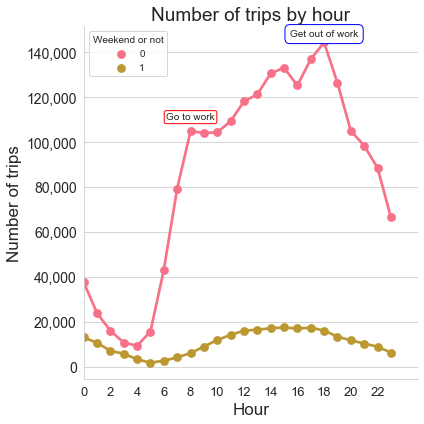

In [57]:
g= sns.FacetGrid(data=numTripByHour,height=6,  legend_out=False)
g.map(sns.pointplot,'PUhour','clipped_trip_distance','PUweekend', palette=sns.color_palette('husl'))
g.add_legend(title='Weekend or not')
g.set(title='Number of trips by hour')
g.set_axis_labels('Hour','Number of trips')
ax=g.axes[0][0]
ax.set_xlim(0,25)
ax.yaxis.set_major_formatter(formatter)
plt.locator_params(axis='x',nbins=12)
ax.text(8,110000,'Go to work',ha='center',
        size=10,
        bbox=dict(boxstyle='round,pad=.2',fc='white',ec='red'))
ax.text(18,147000,'Get out of work', ha='center',
        size=10,
        bbox=dict(boxstyle='round,pad=.5',fc='white',ec='blue'))
plt.tight_layout()
plt.show()

From the point plot, we could tell that during weekend, there is not much difference in the number of trips by hours. On the other hand, speaking of the weekday, we could spot straight away that at 8am and 6pm, there are sudden peaks in the number of trips. 

A possible explanation for them could be that at these specific times in a day, commuters start off to going to work and getting out of work respectively

##### Is there any difference in proportion of the payment type by weekend and weekday?

In [58]:
#Count the total number of each type of payment on the basis of being weekend or not
countPaymentType= initial_trimmed.groupby(['PUweekend','payment_type'])['clipped_trip_distance'].agg('count').reset_index()
countPaymentType.rename({'clipped_trip_distance':'count_payment_type'}, axis=1, inplace=True)

# Compute the proportion of the number of each type of payment
total_trips= countPaymentType.groupby('PUweekend')['count_payment_type'].transform('sum')
countPaymentType['total_trips']=total_trips
countPaymentType['proportion_payment_type']=(countPaymentType['count_payment_type']/countPaymentType['total_trips'])*100

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


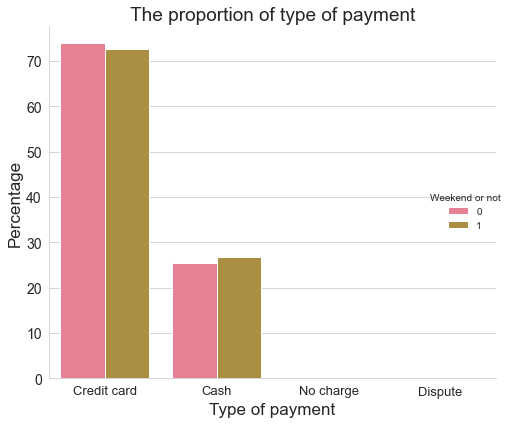

In [59]:
g= sns.FacetGrid(data=countPaymentType, height=6)
g.map(sns.barplot,'payment_type','proportion_payment_type','PUweekend', palette=sns.color_palette('husl'))
g.set(title='The proportion of type of payment')
g.set_axis_labels('Type of payment','Percentage')
g.set_xticklabels(['Credit card','Cash','No charge','Dispute'])
g.add_legend(title='Weekend or not')
plt.tight_layout()
plt.show()

From the clustered barplot above, we could tell that:

+ whether it is weekend or not, the tendency to opt for the payment type of customers does not vary. 


+ credit card turns out to be preferred to cash

##### What is the change in the number of trips by months?

In [60]:
numTripsMonth=initial_trimmed.groupby('PUmonth')['clipped_trip_distance'].agg('count').reset_index()

In [61]:
numTripsMonth.rename({'clipped_trip_distance':'numTrips'},axis=1, inplace=True)

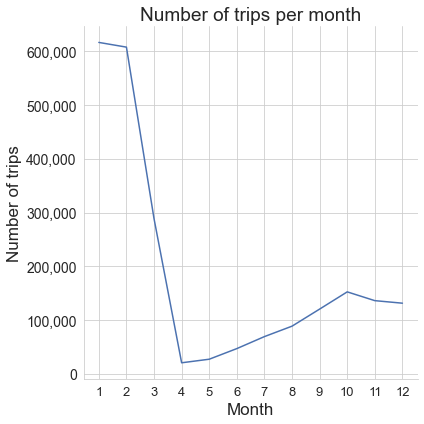

In [62]:
g= sns.FacetGrid(data=numTripsMonth,height=6)
g.map(sns.lineplot,'PUmonth','numTrips', color=sns.color_palette('deep')[0])
g.set(title='Number of trips per month')
g.set_axis_labels('Month','Number of trips')
g.axes[0][0].yaxis.set_major_formatter(formatter)
plt.locator_params(axis='x',nbins=24)
plt.tight_layout()
plt.show()

Obviously, there is a tumble in the number of trips in the first quarter 2020 and it hit the bottom at the start of April. 

It could be explained by the fact that on March 20, 2020, the New York State has put the city on lockdown. The transportation needs dropped sharply as a result of that.

Later, the restrictions has been relaxed a bit and the city was opened again through a campaign of multiple phases. This led to the number of trips rose again. But the rise is rather gradual rather than sudden 

### engineer features

#### add useful columns

##### Categorical encoding

In [63]:
# Create dummies columns for payment_type
pay= pd.get_dummies(initial_trimmed['payment_type'],drop_first=True)
payname= pay.rename(columns=dict(zip(np.arange(2,5),['payCash','payNoCharge','payDispute'])))

In [64]:
# Create dummies column for RatecodeID
rate= pd.get_dummies(initial_trimmed['RatecodeID'],drop_first=True)
ratename = rate.rename(columns=dict(zip(np.arange(2,7),['r2','r3','r4','r5','r6'])))

In [80]:
# Label encoding for categorical variable: day
encoder= LabelEncoder()
PUdayEncoded=pd.Series(encoder.fit_transform(initial_trimmed[['PUday']]),name='PUdayEncoded', index=initial_trimmed.index)
DOdayEncoded=pd.Series(encoder.fit_transform(initial_trimmed[['DOday']]),name='DOdayEncoded',index=initial_trimmed.index)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [104]:
initial_trimmed_encoded= pd.concat((initial_trimmed,ratename,payname,PUdayEncoded,DOdayEncoded),axis=1)

##### Numeric features transforming

As for the cyclic property of month, day, hour, we should do sin cos transform to be able to capture that

In [105]:
#sine cosine transform
initial_trimmed_encoded['PUhoursin']= np.sin(initial_trimmed_encoded['PUhour']*(2.*np.pi/24)) #sin(radians)=>coordinate values on Oy
initial_trimmed_encoded['PUhourcos']= np.cos(initial_trimmed_encoded['PUhour']*(2.*np.pi/24)) #cos(radians)=>coordinate values on Ox
initial_trimmed_encoded['DOhoursin']= np.sin(initial_trimmed_encoded['DOhour']*(2.*np.pi/24)) 
initial_trimmed_encoded['DOhourcos']= np.cos(initial_trimmed_encoded['DOhour']*(2.*np.pi/24)) 


initial_trimmed_encoded['PUdaysin']= np.sin(initial_trimmed_encoded['PUdayEncoded']*(2.*np.pi/7))
initial_trimmed_encoded['PUdaycos']= np.cos(initial_trimmed_encoded['PUdayEncoded']*(2.*np.pi/7))
initial_trimmed_encoded['DOdaysin']= np.sin(initial_trimmed_encoded['DOdayEncoded']*(2.*np.pi/7))
initial_trimmed_encoded['DOdaycos']= np.cos(initial_trimmed_encoded['DOdayEncoded']*(2.*np.pi/7))


initial_trimmed_encoded['PUmonthsin']= np.sin(initial_trimmed_encoded['PUmonth']*(2.*np.pi/12))
initial_trimmed_encoded['PUmonthcos']= np.cos(initial_trimmed_encoded['PUmonth']*(2.*np.pi/12))
initial_trimmed_encoded['DOmonthsin']= np.sin(initial_trimmed_encoded['DOmonth']*(2.*np.pi/12))
initial_trimmed_encoded['DOmonthcos']= np.cos(initial_trimmed_encoded['DOmonth']*(2.*np.pi/12))


For the longitude and latitude of locations, it is better to convert them into the distance between the pick up and drop off points. The distance itself between two places is more intuitive and would be more helpful in doing the fare amount prediction or trip distance prediction.

Here I identified some tourist attractions which are used as the reference places and compute the distance by calling on Harversine distance formula. 

The details of the formulation could be found here:
https://community.esri.com/t5/coordinate-reference-systems-blog/distance-on-a-sphere-the-haversine-formula/ba-p/902128



In [84]:
def detora(List):
    """
    The function converts decimal coordinates to radians coordinates for each specific place
    It requires a list of 2-tuple(decimal longitude, decimal latitude) as the argument.
    It returns the list of 2-tuple (radians longitude, radians latitude)
    """
    res=[]
    for i in List:
        listc= list(map(radians,i))
        res.append(listc)
    return res

#coordinates of some specific places
    #JFKairport
JFKairport= (-73.78, 40.64)
    #NWairport
NWairport=(-74.17, 40.74)
    #Timesquare 
Timesquare = (-73.99,40.76)
    #WorldTradeCente
Wtc=  (-74.01,40.71)
    #BankofAmerica
Boa = (-73.94, 40.82)

L= [JFKairport, NWairport, Timesquare, Wtc, Boa]

listPlaces= detora(L)
listPlaces

[[-1.2877039221214164, 0.7093018080104956],
 [-1.2945107062041943, 0.7110471372624899],
 [-1.2913691135506042, 0.7113962031128886],
 [-1.2917181794010033, 0.7105235384868915],
 [-1.2904964489246071, 0.7124434006640853]]

In [109]:
# convert decimal lon lat to radians for PUlon  PUlat , DOlon, DOlat
initial_trimmed_encoded['PUlonra']= np.radians(initial_trimmed_encoded['PUlon'])
initial_trimmed_encoded['PUlatra']= np.radians(initial_trimmed_encoded['PUlat'])
initial_trimmed_encoded['DOlonra']= np.radians(initial_trimmed_encoded['DOlon'])
initial_trimmed_encoded['DOlatra']= np.radians(initial_trimmed_encoded['DOlat'])

In [86]:
def haversineindf(df):
    """
    Function computes the Harvesine distance between the datapoints and each specific place in the listPlaces.
    It requires a dataframe having 1 column. This is used to concatenate with the results.
    Function returns a dataframe of Harvesine distance
    """
    for i in np.arange(0,len(listPlaces)):
        
        lon1=listPlaces[i][0]
        lon2=initial_trimmed_encoded['PUlonra']
        
        lat1= listPlaces[i][1]
        lat2= initial_trimmed_encoded['PUlatra']
        
        deltaLon= lon2-lon1
        deltaLat= lat2-lat1
        
        a= np.sin(deltaLat/2)**2 + np.cos(lat2) * np.cos(lat1) * np.sin(deltaLon/2)**2
        c= 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        miles=c*3956
        
        miles=miles.rename(i)
        df= pd.concat((df,miles),axis=1)
    return df

In [88]:
def haversineindfpd(df):
    """
    Function computes the Harvesine distance between the pick up point and drop off point.
    It requires a dataframe having 1 column. This is used to concatenate with the results. 
    Function returns a dataframe of Harvesine distance
    """
    lon1=initial_trimmed_encoded['DOlonra']
    lon2=initial_trimmed_encoded['PUlonra']
    
    lat1=initial_trimmed_encoded['DOlatra']
    lat2=initial_trimmed_encoded['PUlatra']
    
    deltaLon= lon2-lon1
    deltaLat= lat2 - lat1
    
    a= np.sin(deltaLat/2)**2 + np.cos(lat2) * np.cos(lat1) * np.sin(deltaLon/2)**2
    c= 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    miles=c*3956
    
    df= pd.concat((df,miles),axis=1)
    return df

In [110]:
s1= pd.DataFrame(np.zeros(len(initial_trimmed_encoded.index)),index=initial_trimmed_encoded.index)
predf= haversineindf(s1)
predfpd= haversineindfpd(s1)

In [111]:
# select only the columns showing the distance between two locations
df=predf.iloc[:,1::]
dfpd=predfpd.iloc[:,1::]

In [112]:
dfname=df.rename(columns=dict(enumerate('tojfk tonw totimes towtc toboa'.split())))
dfpdname=dfpd.rename(columns={0:'pd'})

In [113]:
Xfull= pd.concat((initial_trimmed_encoded,dfname, dfpdname),axis=1)

#### select only useful and relevant columns

In [115]:
Xfull.drop(['PUlon', 'PUlat', 'DOlon', 'DOlat', 'PUmonth', 'PUhour', 'DOmonth',
       'DOhour', 'PUday', 'DOday', 'duration',
        'trip_distance', 'RatecodeID', 'PULocationID','PUdayEncoded', 'DOdayEncoded',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount',  'total_amount',
       'duration_sec','PUlonra', 'PUlatra', 'DOlonra', 'DOlatra'],axis=1, inplace=True)

In [196]:
Xfull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2308850 entries, 0 to 2383892
Data columns (total 39 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PUweekend              int64  
 1   DOweekend              int64  
 2   passenger_count        int64  
 3   improvement_surcharge  float64
 4   congestion_surcharge   float64
 5   clipped_duration_sec   float64
 6   clipped_trip_distance  float64
 7   clipped_fare_amount    float64
 8   clipped_extra          float64
 9   clipped_mta_tax        float64
 10  clipped_tip_amount     float64
 11  clipped_tolls_amount   float64
 12  clipped_total_amount   float64
 13  r2                     uint8  
 14  r3                     uint8  
 15  r4                     uint8  
 16  r5                     uint8  
 17  r6                     uint8  
 18  payCash                uint8  
 19  payNoCharge            uint8  
 20  payDispute             uint8  
 21  PUhoursin              float64
 22  PUhourcos         

# FEATURE SCALING AND PREDICTION 

Due to having a rather large feature design matrix(multiple features and millions of rows), the closed-form formula to work out the coefficients of effects of features suffer from computational complexity. 

That is why we tried to work out the coefficients of parameters by using the gradient descent  i.e: SGDRegressor and SGDClassifier

### Predict trip distance 
(using only the information available at hand at the start of the trip)

In [117]:
ya=Xfull['clipped_trip_distance']

In [118]:
Xa= Xfull.drop(['clipped_trip_distance','pd','clipped_duration_sec','passenger_count','payCash','payNoCharge','payDispute','r2','r3','r4','r5','r6',
       'clipped_fare_amount', 'clipped_extra', 'clipped_mta_tax', 'clipped_tip_amount', 'clipped_tolls_amount',
       'improvement_surcharge', 'clipped_total_amount', 'congestion_surcharge',
       'DOweekend','DOhoursin', 'DOhourcos','DOdaysin','DOdaycos','DOmonthsin','DOmonthcos'],axis=1)


In [189]:
print('Features used are as follows')
pd.Series(Xa.columns.values, name='Features').to_frame()

Features used are as follows


,Features
0,PUweekend
1,PUhoursin
2,PUhourcos
3,PUdaysin
4,PUdaycos
5,PUmonthsin
6,PUmonthcos
7,tojfk
8,tonw
9,totimes


In [173]:
#split the dataset into train set and test set
Xtrain,Xtest,ytraina,ytesta= train_test_split(Xa,ya,test_size=0.2, random_state= 0)

In [174]:
#Scale the features to get shot of any misleading weights allocated for some features
transformer_x = RobustScaler().fit(Xtrain)
Xtraina_trans = pd.DataFrame(transformer_x.transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
Xtesta_trans = pd.DataFrame(transformer_x.transform(Xtest), index=Xtest.index, columns=Xtest.columns)

In [175]:
#Conduct cross-validation to work out which model, which hyperparameters to use
modelhya= SGDRegressor(random_state=0)
hyperparameters= {'loss':['squared_loss','huber','epsilon_insensitive'], 'alpha': np.linspace(0,0.001, 3)} 

In [176]:
grid= GridSearchCV(modelhya, hyperparameters, cv=5, scoring='neg_root_mean_squared_error',n_jobs=-1 )

In [177]:
grid.fit(Xtraina_trans,ytraina)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=0), n_jobs=-1,
             param_grid={'alpha': array([0.    , 0.0005, 0.001 ]),
                         'loss': ['squared_loss', 'huber',
                                  'epsilon_insensitive']},
             scoring='neg_root_mean_squared_error')

In [178]:
comparison = pd.DataFrame(np.abs(grid.cv_results_['mean_test_score']),columns=['Loss'],index=['squared0','huber0','ep0','squared0.0005','huber0.0005','ep.0005','squared0.001','huber0.001','ep0.001'])
pd.options.display.float_format='{:,.5f}'.format
comparison 


,Loss
squared0,2.50750
huber0,2.64118
ep0,2.63848
squared0.0005,2.50748
huber0.0005,2.62642
ep.0005,2.63467
squared0.001,2.50749
huber0.001,2.61720
ep0.001,2.63188


We observed that alpha =0.0005, loss= squared is the best for the hyper parameters combination

In [179]:
#set the best hyperparameter combination found
modela =SGDRegressor(alpha= 0.0005, random_state=0)

In [180]:
modela.fit(Xtraina_trans,ytraina)

SGDRegressor(alpha=0.0005, random_state=0)

In [181]:
print('The R-squared score on train set {:,.4f}'.format(modela.score(Xtraina_trans,ytraina)))

The R-squared score on train set 0.3867


In [182]:
print('The R-squared score on test set {:,.4f}'.format(modela.score(Xtesta_trans,ytesta)))

The R-squared score on test set 0.3870


The score on test set and that on train set look roughly close to each other (i.e: up to two decimals to the right). 

R-squared score 0.38 means that the linear model minimizing a regularized empirical loss with SGD constructed by incorporating features available at the start of the trip could explain 38% variation in the trip distance.

In [183]:
y_pred = modela.predict(Xtesta_trans)
error= pd.Series(ytesta-y_pred, name= 'Error').to_frame()

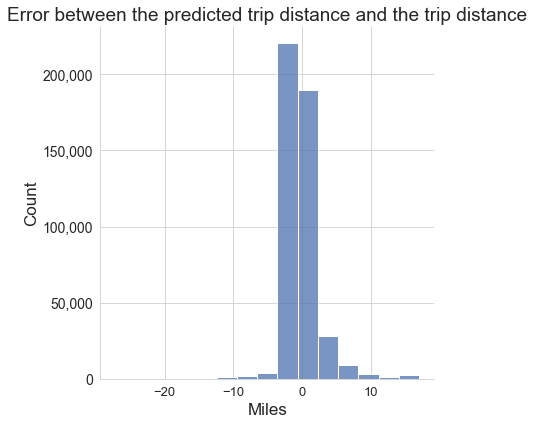

In [184]:
g= sns.FacetGrid(data=error, height=6)
g.map(sns.histplot, 'Error', color=sns.color_palette('deep')[0],bins=15)
g.set(title='Error between the predicted trip distance and the trip distance')
g.set_axis_labels('Miles')
g.axes[0][0].yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

As shown in the histogram of errors, the errors distribution follows the normal distribution. Most of the time, the mass of error concentrates at 0. 

### Predicting fare_amount 
(

+do not make use of features that are clearly related to the fare amount(i.e: extra, tip_amount, tolls_amount,improvement_surcharge, total_amount, congestion_surchage, trip_distance, duration_sec

+work out the parsimonious model. 


)

In [138]:
yb= Xfull['clipped_fare_amount']

In [139]:
Xb =Xfull.drop(['improvement_surcharge',
       'congestion_surcharge', 'clipped_duration_sec', 'clipped_trip_distance',
       'clipped_fare_amount', 'clipped_extra',
       'clipped_tip_amount', 'clipped_tolls_amount', 'clipped_total_amount'],axis=1)

In [190]:
print('Features used are as follows')

pd.Series(Xb.columns.values, name='Features').to_frame()

Features used are as follows


,Features
0,PUweekend
1,DOweekend
2,passenger_count
3,clipped_mta_tax
4,r2
5,r3
6,r4
7,r5
8,r6
9,payCash


In [141]:
# Train test split 
Xtrain,Xtest, ytrain,ytest = train_test_split(Xb,yb,test_size=0.2, random_state= 0)

In [142]:
#Scale the features
transformer_x = RobustScaler().fit(Xtrain)
Xtrain_trans = pd.DataFrame(transformer_x.transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
Xtest_trans = pd.DataFrame(transformer_x.transform(Xtest), index=Xtest.index, columns=Xtest.columns)

In [143]:
# Do the Cross-validation to check which model, which hyperparameters to use
modelhyb= SGDRegressor(random_state=0)
hyperparameters= {'loss':['squared_loss','huber'], 'alpha': [0,0.0001]} 

In [144]:
grid= GridSearchCV(modelhyb, hyperparameters, cv=5, scoring='neg_root_mean_squared_error',n_jobs=-1 )

In [145]:
grid.fit(Xtrain_trans,ytrain)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=0), n_jobs=-1,
             param_grid={'alpha': [0, 0.0001],
                         'loss': ['squared_loss', 'huber']},
             scoring='neg_root_mean_squared_error')

In [146]:
comparison = pd.DataFrame(np.abs(grid.cv_results_['mean_test_score']),columns=['Loss'],index=['squared0','huber0','squared0.0001','huber0.0001']) 

In [147]:
comparison  

,Loss
squared0,3.39439
huber0,3.48237
squared0.0001,3.39481
huber0.0001,3.48485


We observed that alpha =0, loss= squared is the best for the hyper parameters combination

In [149]:
modelb = SGDRegressor(alpha=0,random_state=0)

In an attempt to work out the parimonious model (the simplest model but having the high preditive ability), I did cross validation to find out how many features to go for

In [150]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(modelb, Xtrain_trans, ytrain, cv=5)

In [151]:
print('The average R-squared score on validation set is {:,.4f}'.format(np.mean(scores)))

The average R-squared score on validation set is 0.8652


In [152]:
Xheatmap= pd.concat([Xtrain_trans,ytrain],axis=1)

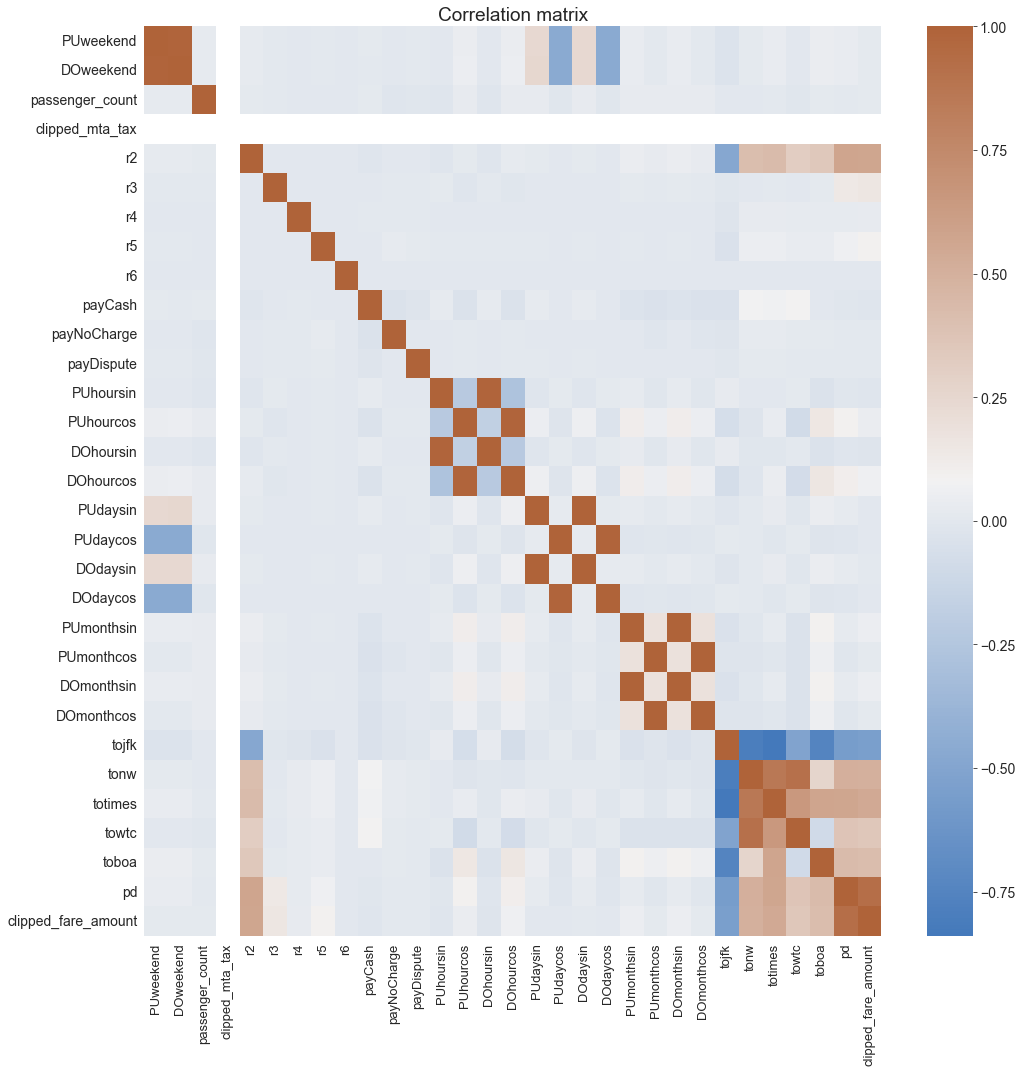

In [154]:
fig, ax= plt.subplots(1,1, figsize=(15,15))
sns.heatmap(data=Xheatmap.corr(),
            cmap=sns.diverging_palette(250,30,as_cmap=True),
            annot=False,
            fmt='g',
            ax=ax)
ax.set_title('Correlation matrix')
plt.tight_layout()
plt.show()
#there is no variation in clipped_mta_tax column. That is why there is a white cross

Pay attention to the clipped_fare_amount at the last row which is our target variable. We see that there seems to have 7 features ('r2', 'pd','tojfk','tonw', 'totimes', 'towtc','toboa') having some non trivial relationship with it. So we only opt for these features to build our model

##### 7 strongest features: 6 distance features + r2

In [155]:
modelb7 = SGDRegressor(alpha=0,random_state=0)
scoresb7 = cross_val_score(modelb7, Xtrain_trans[['pd','tojfk',
       'tonw', 'totimes', 'towtc','toboa','r2' ]], ytrain, cv=5)

In [160]:
print('The average R-squared score on validation set when using only 7 strongest features is {:,.4f}'.format(np.mean(scoresb7)))

The average R-squared score on validation set when using only 7 strongest features is 0.8568


##### Could the model be more parsimonious? 
(1 feature only which is the Harvesine  distance between the pick up and the drop off point (i.e: pd))

In [158]:
modelb1= SGDRegressor(alpha=0,random_state=0)
scoresb1 = cross_val_score(modelb1, pd.DataFrame(Xtrain_trans['pd'],index=Xtrain_trans.index,columns=['pd']), ytrain, cv=5)

In [159]:
print('The average R-squared score on validation set when using only 1 strongest feature is {:,.4f}'.format(np.mean(scoresb1)))

The average R-squared score on validation set when using only 1 strongest features is 0.8532


##### Conclusion: 

1 feature should be best both in terms of the performance of the model and the number of parameters. Let's see how the 1 feature model perform on the test set

In [161]:
finalmodelb= SGDRegressor(alpha=0,random_state=0)
finalmodelb.fit(Xtrain_trans[['pd']],ytrain)

SGDRegressor(alpha=0, random_state=0)

In [162]:
print('The R-squared score on the train set is {:,.4f}'.format(finalmodelb.score(Xtrain_trans[['pd']],ytrain)))

The R-squared score on the train set is 0.8531


In [164]:
print('The R-squared score on the test set is {:,.4f}'.format(finalmodelb.score(Xtest_trans[['pd']],ytest)))

The R-squared score on the test set is 0.8510


The score on test set and that on train set look roughly close to each other (i.e: up to two decimals to the right). 

R-squared score 0.85 means that the linear model minimizing a regularized empirical loss with SGD constructed could explain 85% variation in the fare amount.

In [165]:
y_pred= finalmodelb.predict(Xtest_trans[['pd']])
error =pd.Series(ytest-y_pred, name='Error').to_frame()

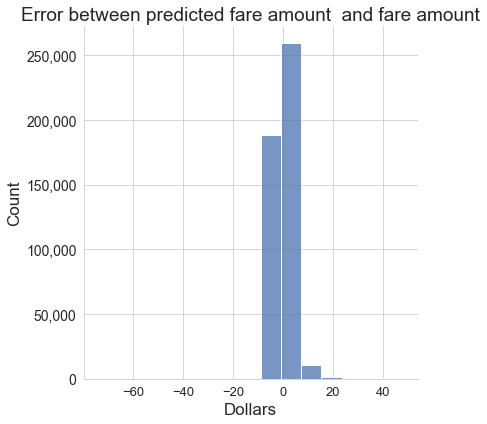

In [167]:
def thousands(y, pos):
    return '{:,.0f}'.format(y)
formatter= FuncFormatter(thousands)
g= sns.FacetGrid(data=error, height=6)
g.map(sns.histplot, 'Error', color=sns.color_palette('deep')[0],bins=15)
g.set(title='Error between predicted fare amount  and fare amount')
g.set_axis_labels('Dollars')
g.axes[0][0].yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

###  Predict payment type
(call on all features)

In [285]:
yc= initial_trimmed_encoded['payment_type']

In [286]:
Xc=Xfull.drop(['payCash', 'payNoCharge', 'payDispute'],axis=1)

In [287]:
Xtrain,Xtest, ytrain,ytest = train_test_split(Xc,yc,test_size=0.2, random_state=0)

In [288]:
transformer_x = RobustScaler().fit(Xtrain)
Xtrain_trans = pd.DataFrame(transformer_x.transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
Xtest_trans = pd.DataFrame(transformer_x.transform(Xtest), index=Xtest.index, columns=Xtest.columns)

Below, I tried to work out the better hyper parameter combinations. Due to such a huge design matrix, I just demonstrated the idea of working out the best hyperparameters in a simple manner

In [291]:
modelclog= SGDClassifier(loss='log',random_state=0)
scoreclog = cross_val_score(modelclog,Xtrain_trans,ytrain, cv=5)

In [298]:
print('The average R-squared on validation set using loss function =\'log\' is: {:,.4f}'.format(np.mean(scoreclog)))

The average R-squared on validation set using Loss function 'log' is: 0.9694


In [294]:
modelcsvc= SGDClassifier(loss='hinge',random_state=0)
scorecsvc = cross_val_score(modelcsvc, Xtrain_trans, ytrain, cv=5)

In [301]:
print('The average R-squared on validation set using loss function = \'hinge\' is: {:,.4f}'.format(np.mean(scorecsvc)))

The average R-squared on validation set using loss function = 'hinge' is: 0.9696


Therefore, we used hyperparameter loss function 'Hinge' 

In [302]:
modelc= SGDClassifier(loss='hinge',random_state=0)

In [303]:
modelc.fit(Xtrain_trans,ytrain)

SGDClassifier(random_state=0)

In [309]:
print('The R-squared score on train set is {:,.4f}'.format(modelc.score(Xtrain_trans,ytrain)))

The R-squared score on train set is 0.9696


In [310]:
print('The  R-squared score on test set is {:,.4f}'.format(modelc.score(Xtest_trans,ytest)))

The  R-squared score on test set is 0.9696


The model is able to capture around 97% variation in the payment type

In [319]:
y_pred= modelc.predict(Xtest_trans)
error=pd.Series(np.abs(ytest-y_pred), name='Error').to_frame()

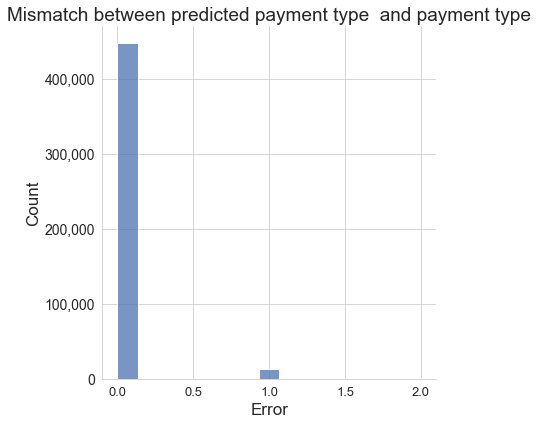

In [320]:
g= sns.FacetGrid(data=error, height=6)
g.map(sns.histplot, 'Error', color=sns.color_palette('deep')[0],bins=15)
g.set(title='Mismatch between predicted payment type  and payment type')
g.axes[0][0].yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

The histogram is in line with the idea above that our model prediction is rather accurate (i.e: being able to capture 97% variation in payment type)